In [1]:
import rosbag
import rospy
import yaml
from geometry_msgs.msg import Twist
from apriltags_ros.msg import *
from tiny_robo_msgs.msg import Motor_Vel_Cmd
import math
import pandas as pd

#Euclidean distance
def dist(a, b):
	assert len(a) == len(b)
	return math.sqrt(sum([math.pow(i-j, 2) for i, j in zip(a,b)]))

In [2]:
bf = "/home/ams/TinyRobo/blue_tank_0.02.bag"
bag = rosbag.Bag(bf)
info_dict = yaml.load(bag._get_yaml_info())

In [3]:
info_dict

{'compression': 'none',
 'duration': 102.558145,
 'end': 1528223167.735654,
 'indexed': True,
 'messages': 2452,
 'path': '/home/ams/TinyRobo/blue_tank_0.02.bag',
 'size': 332426,
 'start': 1528223065.17751,
 'topics': [{'frequency': 7.9848,
   'messages': 928,
   'topic': '/diff_drive_node/drive_cmd',
   'type': 'tiny_robo_msgs/Motor_Vel_Cmd'},
  {'frequency': 6.2478,
   'messages': 596,
   'topic': '/tag_detections',
   'type': 'apriltags_ros/AprilTagDetectionArray'},
  {'frequency': 7.9862,
   'messages': 928,
   'topic': '/ui_twist',
   'type': 'geometry_msgs/Twist'}],
 'types': [{'md5': '2075fb4e2292788f582a625945673fb2',
   'type': 'apriltags_ros/AprilTagDetectionArray'},
  {'md5': '9f195f881246fdfa2798d1d3eebca84a', 'type': 'geometry_msgs/Twist'},
  {'md5': '9f2557e7f3ab1a4fb5a49d1e5d4c5f1a',
   'type': 'tiny_robo_msgs/Motor_Vel_Cmd'}],
 'version': 2.0}

In [4]:
prev_pos = None
prev_pos_time = None
#Set everything to 0 initially
lin_vel = rot_vel = m1 = m2 = vel = 0
#Store everything in a dict indexed by time
events = {}
for topic, msg, t in bag.read_messages():
    if topic == "/ui_twist":
        #Message is a twist message from the calibration UI
        lin_vel = msg.linear.x
        rot_vel = msg.angular.z
    elif topic == "/diff_drive_node/drive_cmd":
        #Message is a Motor_Vel_Cmd
        m1 = msg.motor1
        m2 = msg.motor2
    elif topic == "/tag_detections":
        for tag in msg.detections:
            tag_id = tag.id
            tag_x = tag.pose.pose.position.x
            tag_y = tag.pose.pose.position.y
            #We have a previous pose, so calculate the velocity of the movement
            if prev_pos is not None:
                d = dist((tag_x, tag_y), prev_pos)
                delta_t = t - prev_pos_time
                vel = d/delta_t.to_sec() #In m/sec
            #update previous position and time
            prev_pos = (tag_x, tag_y)
            prev_pos_time = t
    else:
        #This is an error
        print topic, msg, t
    events[t] = [lin_vel, rot_vel, m1, m2, vel]
bag_frame = pd.DataFrame.from_dict(events, orient="index")

In [5]:
by_time = bag_frame.sort_index()
by_time = by_time.rename(columns={0:"lin_vel", 1: "rot_vel", 2: "m1", 3: "m2", 4:"vel"})

In [6]:
import matplotlib.pyplot as plt

#Imbiggen the plots
plt.rcParams['figure.figsize'] = [16,13]

by_time.plot(kind="line")

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


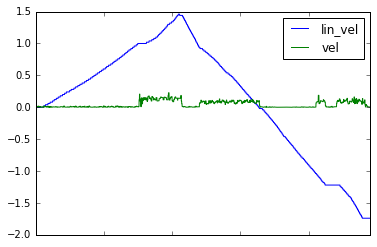

In [7]:
by_time.plot(y=["lin_vel", "vel"], kind="line")

In [8]:
#Load a bagfile and return a dataframe from it
def bagToDF(bagpath):
    bag = rosbag.Bag(bagpath)
    #For calculating velocity
    prev_pos = None
    prev_pos_time = None
    #Set everything to 0 initially
    lin_vel = rot_vel = m1 = m2 = vel = 0
    #Store everything in a dict indexed by time
    events = {}
    for topic, msg, t in bag.read_messages():
        if topic == "/ui_twist":
            #Message is a twist message from the calibration UI
            lin_vel = msg.linear.x
            rot_vel = msg.angular.z
        elif topic == "/diff_drive_node/drive_cmd":
            #Message is a Motor_Vel_Cmd
            m1 = msg.motor1
            m2 = msg.motor2
        elif topic == "/tag_detections":
            for tag in msg.detections:
                tag_id = tag.id
                tag_x = tag.pose.pose.position.x
                tag_y = tag.pose.pose.position.y
                #We have a previous pose, so calculate the velocity of the movement
                if prev_pos is not None:
                    d = dist((tag_x, tag_y), prev_pos)
                    delta_t = t - prev_pos_time
                    vel = d/delta_t.to_sec() #In m/sec
                #update previous position and time
                prev_pos = (tag_x, tag_y)
                prev_pos_time = t
        else:
            #This is an error
            print topic, msg, t
        events[t] = [lin_vel, rot_vel, m1, m2, vel]
    #Create the dataframe, sort by time, and rename the columns
    bag_frame = pd.DataFrame.from_dict(events, orient="index")
    by_time = bag_frame.sort_index()
    by_time = by_time.rename(columns={0:"lin_vel", 1: "rot_vel", 2: "m1", 3: "m2", 4:"vel"})
    return by_time

In [9]:
second_run = bagToDF("/home/ams/TinyRobo/2018-06-05-14-28-39.bag")

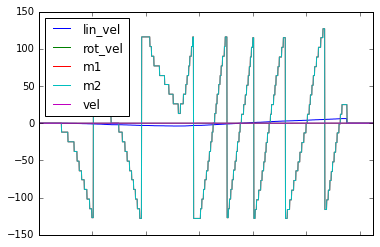

In [10]:
second_run.plot(kind="line")

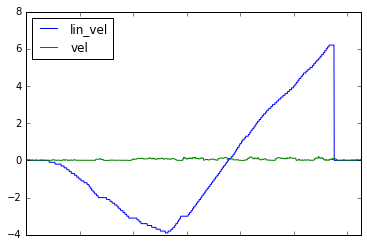

In [11]:
second_run.plot(y=["lin_vel", "vel"], kind="line")

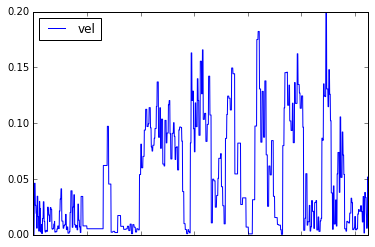

In [12]:
second_run.plot(y=["vel"], kind="line")

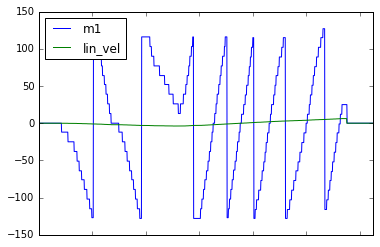

In [13]:
second_run.plot(y=["m1", "lin_vel"], kind="line")

In [14]:
skittish = bagToDF("/home/ams/TinyRobo/2018-06-05-17-52-18.bag")

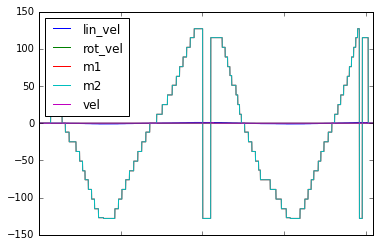

In [15]:
skittish.plot()

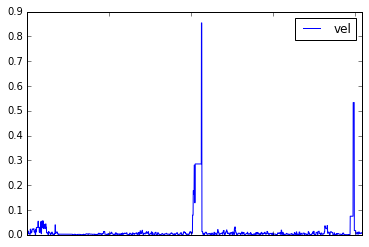

In [16]:
skittish.plot(y=["vel"])

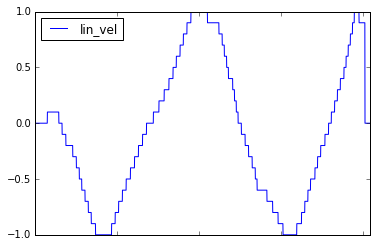

In [17]:
skittish.plot(y=["lin_vel"])

In [18]:
stdout_log ='''[WARN] [1528235540.146139]: (00,0), (00,0)
[WARN] [1528235540.271510]: (00,0), (00,0)
[WARN] [1528235540.399013]: (00,0), (00,0)
[WARN] [1528235540.524336]: (00,0), (00,0)
[WARN] [1528235540.650053]: (00,0), (00,0)
[WARN] [1528235540.774983]: (00,0), (00,0)
[WARN] [1528235540.900505]: (00,0), (00,0)
[WARN] [1528235541.025345]: (00,0), (00,0)
[WARN] [1528235541.150763]: (00,0), (00,0)
[WARN] [1528235541.275925]: (00,0), (00,0)
[WARN] [1528235541.401100]: (00,0), (00,0)
[WARN] [1528235541.528452]: (00,0), (00,0)
[WARN] [1528235541.654470]: (00,0), (00,0)
[WARN] [1528235541.779771]: (00,0), (00,0)
[WARN] [1528235541.904779]: (00,0), (00,0)
[WARN] [1528235542.030074]: (00,0), (00,0)
[WARN] [1528235542.155478]: (00,0), (00,0)
[WARN] [1528235542.280524]: (00,0), (00,0)
[WARN] [1528235542.405761]: (00,0), (00,0)
[WARN] [1528235542.530923]: (00,0), (00,0)
[WARN] [1528235542.558433]: (04,1), (04,1)
[WARN] [1528235542.683853]: (04,1), (04,1)
[WARN] [1528235542.808574]: (04,1), (04,1)
[WARN] [1528235542.933986]: (04,1), (04,1)
[WARN] [1528235543.059453]: (04,1), (04,1)
[WARN] [1528235543.184846]: (04,1), (04,1)
[WARN] [1528235543.309916]: (04,1), (04,1)
[WARN] [1528235543.435153]: (04,1), (04,1)
[WARN] [1528235543.560856]: (04,1), (04,1)
[WARN] [1528235543.685778]: (04,1), (04,1)
[WARN] [1528235543.811002]: (04,1), (04,1)
[WARN] [1528235543.936164]: (04,1), (04,1)
[WARN] [1528235544.061378]: (04,1), (04,1)
[WARN] [1528235544.187470]: (04,1), (04,1)
[WARN] [1528235544.311992]: (04,1), (04,1)
[WARN] [1528235544.437218]: (04,1), (04,1)
[WARN] [1528235544.562739]: (04,1), (04,1)
[WARN] [1528235544.688101]: (04,1), (04,1)
[WARN] [1528235544.813866]: (04,1), (04,1)
[WARN] [1528235544.939016]: (04,1), (04,1)
[WARN] [1528235545.064642]: (04,1), (04,1)
[WARN] [1528235545.189551]: (04,1), (04,1)
[WARN] [1528235545.315430]: (04,1), (04,1)
[WARN] [1528235545.383241]: (00,0), (00,0)
[WARN] [1528235545.508935]: (00,0), (00,0)
[WARN] [1528235545.633502]: (00,0), (00,0)
[WARN] [1528235545.759327]: (00,0), (00,0)
[WARN] [1528235545.884021]: (00,0), (00,0)
[WARN] [1528235546.009444]: (00,0), (00,0)
[WARN] [1528235546.134804]: (00,0), (00,0)
[WARN] [1528235546.174670]: (04,2), (04,2)
[WARN] [1528235546.301308]: (04,2), (04,2)
[WARN] [1528235546.425515]: (04,2), (04,2)
[WARN] [1528235546.550914]: (04,2), (04,2)
[WARN] [1528235546.675901]: (04,2), (04,2)
[WARN] [1528235546.800943]: (04,2), (04,2)
[WARN] [1528235546.926403]: (04,2), (04,2)
[WARN] [1528235547.051740]: (04,2), (04,2)
[WARN] [1528235547.174857]: (09,2), (09,2)
[WARN] [1528235547.301357]: (09,2), (09,2)
[WARN] [1528235547.425502]: (09,2), (09,2)
[WARN] [1528235547.551442]: (09,2), (09,2)
[WARN] [1528235547.678562]: (09,2), (09,2)
[WARN] [1528235547.805017]: (09,2), (09,2)
[WARN] [1528235547.930402]: (09,2), (09,2)
[WARN] [1528235548.056264]: (09,2), (09,2)
[WARN] [1528235548.187586]: (09,2), (09,2)
[WARN] [1528235548.314750]: (09,2), (09,2)
[WARN] [1528235548.436797]: (09,2), (09,2)
[WARN] [1528235548.562727]: (09,2), (09,2)
[WARN] [1528235548.688192]: (09,2), (09,2)
[WARN] [1528235548.816700]: (09,2), (09,2)
[WARN] [1528235548.939532]: (09,2), (09,2)
[WARN] [1528235549.066132]: (09,2), (09,2)
[WARN] [1528235549.194788]: (09,2), (09,2)
[WARN] [1528235549.322824]: (09,2), (09,2)
[WARN] [1528235549.443298]: (09,2), (09,2)
[WARN] [1528235549.470725]: (0E,2), (0E,2)
[WARN] [1528235549.594387]: (0E,2), (0E,2)
[WARN] [1528235549.723230]: (0E,2), (0E,2)
[WARN] [1528235549.849344]: (0E,2), (0E,2)
[WARN] [1528235549.973929]: (0E,2), (0E,2)
[WARN] [1528235550.100136]: (0E,2), (0E,2)
[WARN] [1528235550.225013]: (0E,2), (0E,2)
[WARN] [1528235550.352238]: (0E,2), (0E,2)
[WARN] [1528235550.476809]: (0E,2), (0E,2)
[WARN] [1528235550.604169]: (0E,2), (0E,2)
[WARN] [1528235550.728580]: (0E,2), (0E,2)
[WARN] [1528235550.827860]: (13,2), (13,2)
[WARN] [1528235550.956869]: (13,2), (13,2)
[WARN] [1528235551.086972]: (13,2), (13,2)
[WARN] [1528235551.210428]: (13,2), (13,2)
[WARN] [1528235551.336669]: (13,2), (13,2)
[WARN] [1528235551.462646]: (13,2), (13,2)
[WARN] [1528235551.588118]: (13,2), (13,2)
[WARN] [1528235551.713041]: (13,2), (13,2)
[WARN] [1528235551.844338]: (13,2), (13,2)
[WARN] [1528235551.849982]: (18,2), (18,2)
[WARN] [1528235551.976456]: (18,2), (18,2)
[WARN] [1528235552.103284]: (18,2), (18,2)
[WARN] [1528235552.228037]: (18,2), (18,2)
[WARN] [1528235552.354585]: (18,2), (18,2)
[WARN] [1528235552.480714]: (18,2), (18,2)
[WARN] [1528235552.607712]: (18,2), (18,2)
[WARN] [1528235552.686187]: (1C,2), (1C,2)
[WARN] [1528235552.813396]: (1C,2), (1C,2)
[WARN] [1528235552.938283]: (1C,2), (1C,2)
[WARN] [1528235553.064744]: (1C,2), (1C,2)
[WARN] [1528235553.190408]: (1C,2), (1C,2)
[WARN] [1528235553.316186]: (1C,2), (1C,2)
[WARN] [1528235553.448488]: (1C,2), (1C,2)
[WARN] [1528235553.574108]: (1C,2), (1C,2)
[WARN] [1528235553.699905]: (1C,2), (1C,2)
[WARN] [1528235553.765133]: (21,2), (21,2)
[WARN] [1528235553.890972]: (21,2), (21,2)
[WARN] [1528235554.017678]: (21,2), (21,2)
[WARN] [1528235554.143336]: (21,2), (21,2)
[WARN] [1528235554.268654]: (21,2), (21,2)
[WARN] [1528235554.394265]: (21,2), (21,2)
[WARN] [1528235554.519705]: (21,2), (21,2)
[WARN] [1528235554.647887]: (21,2), (21,2)
[WARN] [1528235554.776163]: (21,2), (21,2)
[WARN] [1528235554.817162]: (26,2), (26,2)
[WARN] [1528235554.940508]: (26,2), (26,2)
[WARN] [1528235555.065280]: (26,2), (26,2)
[WARN] [1528235555.191586]: (26,2), (26,2)
[WARN] [1528235555.317237]: (26,2), (26,2)
[WARN] [1528235555.443193]: (26,2), (26,2)
[WARN] [1528235555.570831]: (26,2), (26,2)
[WARN] [1528235555.694237]: (26,2), (26,2)
[WARN] [1528235555.765020]: (2B,2), (2B,2)
[WARN] [1528235555.892324]: (2B,2), (2B,2)
[WARN] [1528235556.016840]: (2B,2), (2B,2)
[WARN] [1528235556.142470]: (2B,2), (2B,2)
[WARN] [1528235556.270473]: (2B,2), (2B,2)
[WARN] [1528235556.393422]: (2B,2), (2B,2)
[WARN] [1528235556.521548]: (2B,2), (2B,2)
[WARN] [1528235556.647261]: (2B,2), (2B,2)
[WARN] [1528235556.771792]: (2B,2), (2B,2)
[WARN] [1528235556.898012]: (2B,2), (2B,2)
[WARN] [1528235556.902291]: (2F,2), (2F,2)
[WARN] [1528235557.024421]: (2F,2), (2F,2)
[WARN] [1528235557.149948]: (2F,2), (2F,2)
[WARN] [1528235557.275006]: (2F,2), (2F,2)
[WARN] [1528235557.400530]: (2F,2), (2F,2)
[WARN] [1528235557.526026]: (2F,2), (2F,2)
[WARN] [1528235557.651715]: (2F,2), (2F,2)
[WARN] [1528235557.780066]: (2F,2), (2F,2)
[WARN] [1528235557.906371]: (2F,2), (2F,2)
[WARN] [1528235558.031267]: (2F,2), (2F,2)
[WARN] [1528235558.156698]: (2F,2), (2F,2)
[WARN] [1528235558.283087]: (2F,2), (2F,2)
[WARN] [1528235558.290316]: (30,2), (30,2)
[WARN] [1528235558.418486]: (30,2), (30,2)
[WARN] [1528235558.541216]: (30,2), (30,2)
[WARN] [1528235558.666468]: (30,2), (30,2)
[WARN] [1528235558.791998]: (30,2), (30,2)
[WARN] [1528235558.916813]: (30,2), (30,2)
[WARN] [1528235559.042501]: (30,2), (30,2)
[WARN] [1528235559.169351]: (30,2), (30,2)
[WARN] [1528235559.293865]: (30,2), (30,2)
[WARN] [1528235559.419595]: (30,2), (30,2)
[WARN] [1528235559.544484]: (30,2), (30,2)
[WARN] [1528235559.669397]: (30,2), (30,2)
[WARN] [1528235559.795041]: (30,2), (30,2)
[WARN] [1528235559.920275]: (30,2), (30,2)
[WARN] [1528235560.046476]: (30,2), (30,2)
[WARN] [1528235560.170819]: (30,2), (30,2)
[WARN] [1528235560.300020]: (30,2), (30,2)
[WARN] [1528235560.424856]: (30,2), (30,2)
[WARN] [1528235560.550430]: (30,2), (30,2)
[WARN] [1528235560.675708]: (30,2), (30,2)
[WARN] [1528235560.801284]: (30,2), (30,2)
[WARN] [1528235560.929896]: (30,2), (30,2)
[WARN] [1528235561.051824]: (30,2), (30,2)
[WARN] [1528235561.179787]: (30,2), (30,2)
[WARN] [1528235561.302525]: (30,2), (30,2)
[WARN] [1528235561.427922]: (30,2), (30,2)
[WARN] [1528235561.504289]: (2B,2), (2B,2)
[WARN] [1528235561.629641]: (2B,2), (2B,2)
[WARN] [1528235561.755312]: (2B,2), (2B,2)
[WARN] [1528235561.881785]: (2B,2), (2B,2)
[WARN] [1528235562.006819]: (2B,2), (2B,2)
[WARN] [1528235562.133449]: (2B,2), (2B,2)
[WARN] [1528235562.258010]: (2B,2), (2B,2)
[WARN] [1528235562.384149]: (2B,2), (2B,2)
[WARN] [1528235562.481939]: (26,2), (26,2)
[WARN] [1528235562.607129]: (26,2), (26,2)
[WARN] [1528235562.732224]: (26,2), (26,2)
[WARN] [1528235562.857409]: (26,2), (26,2)
[WARN] [1528235562.982784]: (26,2), (26,2)
[WARN] [1528235563.107647]: (26,2), (26,2)
[WARN] [1528235563.233569]: (26,2), (26,2)
[WARN] [1528235563.358730]: (26,2), (26,2)
[WARN] [1528235563.461056]: (21,2), (21,2)
[WARN] [1528235563.586356]: (21,2), (21,2)
[WARN] [1528235563.711664]: (21,2), (21,2)
[WARN] [1528235563.836713]: (21,2), (21,2)
[WARN] [1528235563.961831]: (21,2), (21,2)
[WARN] [1528235564.088159]: (21,2), (21,2)
[WARN] [1528235564.213846]: (21,2), (21,2)
[WARN] [1528235564.339237]: (21,2), (21,2)
[WARN] [1528235564.362789]: (1C,2), (1C,2)
[WARN] [1528235564.488516]: (1C,2), (1C,2)
[WARN] [1528235564.613656]: (1C,2), (1C,2)
[WARN] [1528235564.739048]: (1C,2), (1C,2)
[WARN] [1528235564.864570]: (1C,2), (1C,2)
[WARN] [1528235564.989623]: (1C,2), (1C,2)
[WARN] [1528235565.115144]: (1C,2), (1C,2)
[WARN] [1528235565.240049]: (1C,2), (1C,2)
[WARN] [1528235565.295373]: (18,2), (18,2)
[WARN] [1528235565.422398]: (18,2), (18,2)
[WARN] [1528235565.546227]: (18,2), (18,2)
[WARN] [1528235565.671364]: (18,2), (18,2)
[WARN] [1528235565.796655]: (18,2), (18,2)
[WARN] [1528235565.921770]: (18,2), (18,2)
[WARN] [1528235566.047227]: (18,2), (18,2)
[WARN] [1528235566.172986]: (18,2), (18,2)
[WARN] [1528235566.299414]: (18,2), (18,2)
[WARN] [1528235566.378087]: (13,2), (13,2)
[WARN] [1528235566.500660]: (13,2), (13,2)
[WARN] [1528235566.625871]: (13,2), (13,2)
[WARN] [1528235566.751208]: (13,2), (13,2)
[WARN] [1528235566.877169]: (13,2), (13,2)
[WARN] [1528235567.002323]: (13,2), (13,2)
[WARN] [1528235567.127440]: (13,2), (13,2)
[WARN] [1528235567.252935]: (13,2), (13,2)
[WARN] [1528235567.378149]: (13,2), (13,2)
[WARN] [1528235567.409166]: (0E,2), (0E,2)
[WARN] [1528235567.534294]: (0E,2), (0E,2)
[WARN] [1528235567.659393]: (0E,2), (0E,2)
[WARN] [1528235567.785328]: (0E,2), (0E,2)
[WARN] [1528235567.910003]: (0E,2), (0E,2)
[WARN] [1528235568.035487]: (0E,2), (0E,2)
[WARN] [1528235568.160508]: (0E,2), (0E,2)
[WARN] [1528235568.287992]: (0E,2), (0E,2)
[WARN] [1528235568.326865]: (09,2), (09,2)
[WARN] [1528235568.451991]: (09,2), (09,2)
[WARN] [1528235568.577415]: (09,2), (09,2)
[WARN] [1528235568.702637]: (09,2), (09,2)
[WARN] [1528235568.827895]: (09,2), (09,2)
[WARN] [1528235568.953099]: (09,2), (09,2)
[WARN] [1528235569.080643]: (09,2), (09,2)
[WARN] [1528235569.204620]: (09,2), (09,2)
[WARN] [1528235569.263390]: (04,2), (04,2)
[WARN] [1528235569.388507]: (04,2), (04,2)
[WARN] [1528235569.513519]: (04,2), (04,2)
[WARN] [1528235569.639082]: (04,2), (04,2)
[WARN] [1528235569.763937]: (04,2), (04,2)
[WARN] [1528235569.889353]: (04,2), (04,2)
[WARN] [1528235570.014599]: (04,2), (04,2)
[WARN] [1528235570.139695]: (04,2), (04,2)
[WARN] [1528235570.198867]: (00,0), (00,0)
[WARN] [1528235570.324033]: (00,0), (00,0)
[WARN] [1528235570.449360]: (00,0), (00,0)
[WARN] [1528235570.574813]: (00,0), (00,0)
[WARN] [1528235570.699531]: (00,0), (00,0)
[WARN] [1528235570.824902]: (00,0), (00,0)
[WARN] [1528235570.950051]: (00,0), (00,0)
[WARN] [1528235571.075626]: (00,0), (00,0)
[WARN] [1528235571.200873]: (00,0), (00,0)
[WARN] [1528235571.325916]: (00,0), (00,0)
[WARN] [1528235571.452154]: (00,0), (00,0)
[WARN] [1528235571.576144]: (00,0), (00,0)
[WARN] [1528235571.701927]: (00,0), (00,0)
[WARN] [1528235571.827261]: (00,0), (00,0)
[WARN] [1528235571.855775]: (04,1), (04,1)
[WARN] [1528235571.983154]: (04,1), (04,1)
[WARN] [1528235572.106470]: (04,1), (04,1)
[WARN] [1528235572.231542]: (04,1), (04,1)
[WARN] [1528235572.356846]: (04,1), (04,1)
[WARN] [1528235572.481985]: (04,1), (04,1)
[WARN] [1528235572.607408]: (04,1), (04,1)
[WARN] [1528235572.732689]: (04,1), (04,1)
[WARN] [1528235572.857634]: (04,1), (04,1)
[WARN] [1528235572.983216]: (04,1), (04,1)
[WARN] [1528235573.108596]: (04,1), (04,1)
[WARN] [1528235573.233610]: (04,1), (04,1)
[WARN] [1528235573.271610]: (09,1), (09,1)
[WARN] [1528235573.396782]: (09,1), (09,1)
[WARN] [1528235573.521958]: (09,1), (09,1)
[WARN] [1528235573.647391]: (09,1), (09,1)
[WARN] [1528235573.774884]: (09,1), (09,1)
[WARN] [1528235573.900535]: (09,1), (09,1)
[WARN] [1528235574.025821]: (09,1), (09,1)
[WARN] [1528235574.152651]: (09,1), (09,1)
[WARN] [1528235574.277742]: (09,1), (09,1)
[WARN] [1528235574.404297]: (09,1), (09,1)
[WARN] [1528235574.529862]: (09,1), (09,1)
[WARN] [1528235574.575636]: (0E,1), (0E,1)
[WARN] [1528235574.701194]: (0E,1), (0E,1)
[WARN] [1528235574.826158]: (0E,1), (0E,1)
[WARN] [1528235574.953251]: (0E,1), (0E,1)
[WARN] [1528235575.078371]: (0E,1), (0E,1)
[WARN] [1528235575.203432]: (0E,1), (0E,1)
[WARN] [1528235575.329225]: (0E,1), (0E,1)
[WARN] [1528235575.454465]: (0E,1), (0E,1)
[WARN] [1528235575.580617]: (0E,1), (0E,1)
[WARN] [1528235575.705510]: (0E,1), (0E,1)
[WARN] [1528235575.795250]: (13,1), (13,1)
[WARN] [1528235575.921371]: (13,1), (13,1)
[WARN] [1528235576.046736]: (13,1), (13,1)
[WARN] [1528235576.172805]: (13,1), (13,1)
[WARN] [1528235576.298306]: (13,1), (13,1)
[WARN] [1528235576.423034]: (13,1), (13,1)
[WARN] [1528235576.548778]: (13,1), (13,1)
[WARN] [1528235576.674600]: (13,1), (13,1)
[WARN] [1528235576.799876]: (13,1), (13,1)
[WARN] [1528235576.925108]: (13,1), (13,1)
[WARN] [1528235576.944696]: (17,1), (17,1)
[WARN] [1528235577.069620]: (17,1), (17,1)
[WARN] [1528235577.195777]: (17,1), (17,1)
[WARN] [1528235577.321223]: (17,1), (17,1)
[WARN] [1528235577.447315]: (17,1), (17,1)
[WARN] [1528235577.572454]: (17,1), (17,1)
[WARN] [1528235577.698610]: (17,1), (17,1)
[WARN] [1528235577.823023]: (17,1), (17,1)
[WARN] [1528235577.889150]: (1C,1), (1C,1)
[WARN] [1528235578.013814]: (1C,1), (1C,1)
[WARN] [1528235578.139790]: (1C,1), (1C,1)
[WARN] [1528235578.265889]: (1C,1), (1C,1)
[WARN] [1528235578.393653]: (1C,1), (1C,1)
[WARN] [1528235578.520999]: (1C,1), (1C,1)
[WARN] [1528235578.644901]: (1C,1), (1C,1)
[WARN] [1528235578.772063]: (1C,1), (1C,1)
[WARN] [1528235578.896819]: (1C,1), (1C,1)
[WARN] [1528235578.971569]: (21,1), (21,1)
[WARN] [1528235579.096396]: (21,1), (21,1)
[WARN] [1528235579.222541]: (21,1), (21,1)
[WARN] [1528235579.347289]: (21,1), (21,1)
[WARN] [1528235579.472898]: (21,1), (21,1)
[WARN] [1528235579.597643]: (21,1), (21,1)
[WARN] [1528235579.723167]: (21,1), (21,1)
[WARN] [1528235579.848536]: (21,1), (21,1)
[WARN] [1528235579.955183]: (26,1), (26,1)
[WARN] [1528235580.080826]: (26,1), (26,1)
[WARN] [1528235580.206809]: (26,1), (26,1)
[WARN] [1528235580.331344]: (26,1), (26,1)
[WARN] [1528235580.456284]: (26,1), (26,1)
[WARN] [1528235580.583377]: (26,1), (26,1)
[WARN] [1528235580.710249]: (26,1), (26,1)
[WARN] [1528235580.835130]: (26,1), (26,1)
[WARN] [1528235580.883785]: (2B,1), (2B,1)
[WARN] [1528235581.009832]: (2B,1), (2B,1)
[WARN] [1528235581.135261]: (2B,1), (2B,1)
[WARN] [1528235581.260697]: (2B,1), (2B,1)
[WARN] [1528235581.385878]: (2B,1), (2B,1)
[WARN] [1528235581.511478]: (2B,1), (2B,1)
[WARN] [1528235581.636969]: (2B,1), (2B,1)
[WARN] [1528235581.762746]: (2B,1), (2B,1)
[WARN] [1528235581.888011]: (2B,1), (2B,1)
[WARN] [1528235581.893968]: (2F,1), (2F,1)
[WARN] [1528235582.019143]: (2F,1), (2F,1)
[WARN] [1528235582.144089]: (2F,1), (2F,1)
[WARN] [1528235582.270297]: (2F,1), (2F,1)
[WARN] [1528235582.395688]: (2F,1), (2F,1)
[WARN] [1528235582.522701]: (2F,1), (2F,1)
[WARN] [1528235582.645998]: (2F,1), (2F,1)
[WARN] [1528235582.773455]: (2F,1), (2F,1)
[WARN] [1528235582.899319]: (2F,1), (2F,1)
[WARN] [1528235583.024697]: (2F,1), (2F,1)
[WARN] [1528235583.150224]: (2F,1), (2F,1)
[WARN] [1528235583.275597]: (2F,1), (2F,1)
[WARN] [1528235583.400621]: (2F,1), (2F,1)
[WARN] [1528235583.525908]: (2F,1), (2F,1)
[WARN] [1528235583.651266]: (2F,1), (2F,1)
[WARN] [1528235583.776211]: (2F,1), (2F,1)
[WARN] [1528235583.902546]: (2F,1), (2F,1)
[WARN] [1528235584.027838]: (2F,1), (2F,1)
[WARN] [1528235584.152695]: (2F,1), (2F,1)
[WARN] [1528235584.183683]: (30,2), (30,2)
[WARN] [1528235584.308707]: (30,2), (30,2)
[WARN] [1528235584.434871]: (30,2), (30,2)
[WARN] [1528235584.559761]: (30,2), (30,2)
[WARN] [1528235584.684912]: (30,2), (30,2)
[WARN] [1528235584.810412]: (30,2), (30,2)
[WARN] [1528235584.935376]: (30,2), (30,2)
[WARN] [1528235585.060761]: (30,2), (30,2)
[WARN] [1528235585.185845]: (30,2), (30,2)
[WARN] [1528235585.311624]: (30,2), (30,2)
[WARN] [1528235585.436621]: (30,2), (30,2)
[WARN] [1528235585.561856]: (30,2), (30,2)
[WARN] [1528235585.686983]: (30,2), (30,2)
[WARN] [1528235585.811999]: (30,2), (30,2)
[WARN] [1528235585.937600]: (30,2), (30,2)
[WARN] [1528235586.063924]: (30,2), (30,2)
[WARN] [1528235586.189124]: (30,2), (30,2)
[WARN] [1528235586.255522]: (2B,1), (2B,1)
[WARN] [1528235586.381070]: (2B,1), (2B,1)
[WARN] [1528235586.506549]: (2B,1), (2B,1)
[WARN] [1528235586.632816]: (2B,1), (2B,1)
[WARN] [1528235586.756786]: (2B,1), (2B,1)
[WARN] [1528235586.882073]: (2B,1), (2B,1)
[WARN] [1528235587.007446]: (2B,1), (2B,1)
[WARN] [1528235587.133128]: (2B,1), (2B,1)
[WARN] [1528235587.258788]: (2B,1), (2B,1)
[WARN] [1528235587.384007]: (2B,1), (2B,1)
[WARN] [1528235587.509935]: (2B,1), (2B,1)
[WARN] [1528235587.634909]: (2B,1), (2B,1)
[WARN] [1528235587.760117]: (2B,1), (2B,1)
[WARN] [1528235587.885798]: (2B,1), (2B,1)
[WARN] [1528235588.011726]: (2B,1), (2B,1)
[WARN] [1528235588.136433]: (2B,1), (2B,1)
[WARN] [1528235588.262455]: (2B,1), (2B,1)
[WARN] [1528235588.387210]: (2B,1), (2B,1)
[WARN] [1528235588.513330]: (2B,1), (2B,1)
[WARN] [1528235588.639041]: (2B,1), (2B,1)
[WARN] [1528235588.764289]: (2B,1), (2B,1)
[WARN] [1528235588.890053]: (2B,1), (2B,1)
[WARN] [1528235589.014733]: (2B,1), (2B,1)
[WARN] [1528235589.140714]: (2B,1), (2B,1)
[WARN] [1528235589.265822]: (2B,1), (2B,1)
[WARN] [1528235589.370330]: (26,1), (26,1)
[WARN] [1528235589.495759]: (26,1), (26,1)
[WARN] [1528235589.621067]: (26,1), (26,1)
[WARN] [1528235589.746815]: (26,1), (26,1)
[WARN] [1528235589.871623]: (26,1), (26,1)
[WARN] [1528235590.000930]: (26,1), (26,1)
[WARN] [1528235590.126555]: (26,1), (26,1)
[WARN] [1528235590.176953]: (21,1), (21,1)
[WARN] [1528235590.302002]: (21,1), (21,1)
[WARN] [1528235590.427060]: (21,1), (21,1)
[WARN] [1528235590.552668]: (21,1), (21,1)
[WARN] [1528235590.677962]: (21,1), (21,1)
[WARN] [1528235590.801741]: (1C,1), (1C,1)
[WARN] [1528235590.926843]: (1C,1), (1C,1)
[WARN] [1528235591.052350]: (1C,1), (1C,1)
[WARN] [1528235591.177969]: (1C,1), (1C,1)
[WARN] [1528235591.303349]: (1C,1), (1C,1)
[WARN] [1528235591.424302]: (18,1), (18,1)
[WARN] [1528235591.549422]: (18,1), (18,1)
[WARN] [1528235591.674194]: (18,1), (18,1)
[WARN] [1528235591.800042]: (18,1), (18,1)
[WARN] [1528235591.887898]: (13,1), (13,1)
[WARN] [1528235592.013203]: (13,1), (13,1)
[WARN] [1528235592.138440]: (13,1), (13,1)
[WARN] [1528235592.263823]: (13,1), (13,1)
[WARN] [1528235592.389200]: (13,1), (13,1)
[WARN] [1528235592.514629]: (13,1), (13,1)
[WARN] [1528235592.642740]: (13,1), (13,1)
[WARN] [1528235592.768040]: (13,1), (13,1)
[WARN] [1528235592.893344]: (13,1), (13,1)
[WARN] [1528235592.929369]: (0E,1), (0E,1)
[WARN] [1528235593.054538]: (0E,1), (0E,1)
[WARN] [1528235593.179854]: (0E,1), (0E,1)
[WARN] [1528235593.305145]: (0E,1), (0E,1)
[WARN] [1528235593.376204]: (09,1), (09,1)
[WARN] [1528235593.501575]: (09,1), (09,1)
[WARN] [1528235593.626777]: (09,1), (09,1)
[WARN] [1528235593.752145]: (09,1), (09,1)
[WARN] [1528235593.800340]: (04,1), (04,1)
[WARN] [1528235593.925584]: (04,1), (04,1)
[WARN] [1528235594.050970]: (04,1), (04,1)
[WARN] [1528235594.175931]: (04,1), (04,1)
[WARN] [1528235594.200300]: (00,0), (00,0)
[WARN] [1528235594.325567]: (00,0), (00,0)
[WARN] [1528235594.450693]: (00,0), (00,0)
[WARN] [1528235594.575585]: (00,0), (00,0)
[WARN] [1528235594.700887]: (00,0), (00,0)
[WARN] [1528235594.826288]: (00,0), (00,0)
[WARN] [1528235594.951910]: (00,0), (00,0)
[WARN] [1528235594.992131]: (04,2), (04,2)
[WARN] [1528235595.116828]: (04,2), (04,2)
[WARN] [1528235595.242510]: (04,2), (04,2)
[WARN] [1528235595.368341]: (04,2), (04,2)
[WARN] [1528235595.493783]: (04,2), (04,2)
[WARN] [1528235595.619635]: (04,2), (04,2)
[WARN] [1528235595.744457]: (04,2), (04,2)
[WARN] [1528235595.869397]: (04,2), (04,2)
[WARN] [1528235595.952639]: (09,2), (09,2)
[WARN] [1528235596.077734]: (09,2), (09,2)
[WARN] [1528235596.202858]: (09,2), (09,2)
[WARN] [1528235596.327809]: (09,2), (09,2)
[WARN] [1528235596.453564]: (09,2), (09,2)
[WARN] [1528235596.579374]: (09,2), (09,2)
[WARN] [1528235596.704404]: (09,2), (09,2)
[WARN] [1528235596.829437]: (09,2), (09,2)
[WARN] [1528235596.864677]: (0E,2), (0E,2)
[WARN] [1528235596.990386]: (0E,2), (0E,2)
[WARN] [1528235597.115197]: (0E,2), (0E,2)
[WARN] [1528235597.240451]: (0E,2), (0E,2)
[WARN] [1528235597.366288]: (0E,2), (0E,2)
[WARN] [1528235597.491456]: (0E,2), (0E,2)
[WARN] [1528235597.616457]: (0E,2), (0E,2)
[WARN] [1528235597.741458]: (0E,2), (0E,2)
[WARN] [1528235597.819810]: (13,2), (13,2)
[WARN] [1528235597.948661]: (13,2), (13,2)
[WARN] [1528235598.073767]: (13,2), (13,2)
[WARN] [1528235598.199353]: (13,2), (13,2)
[WARN] [1528235598.324256]: (13,2), (13,2)
[WARN] [1528235598.449939]: (13,2), (13,2)
[WARN] [1528235598.577690]: (13,2), (13,2)
[WARN] [1528235598.672938]: (17,2), (17,2)
[WARN] [1528235598.798485]: (17,2), (17,2)
[WARN] [1528235598.923579]: (17,2), (17,2)
[WARN] [1528235599.048750]: (17,2), (17,2)
[WARN] [1528235599.105052]: (1C,2), (1C,2)
[WARN] [1528235599.230895]: (1C,2), (1C,2)
[WARN] [1528235599.356201]: (1C,2), (1C,2)
[WARN] [1528235599.481696]: (1C,2), (1C,2)
[WARN] [1528235599.606511]: (1C,2), (1C,2)
[WARN] [1528235599.731902]: (1C,2), (1C,2)
[WARN] [1528235599.857441]: (1C,2), (1C,2)
[WARN] [1528235599.982859]: (1C,2), (1C,2)
[WARN] [1528235600.108211]: (1C,2), (1C,2)
[WARN] [1528235600.233491]: (1C,2), (1C,2)
[WARN] [1528235600.359024]: (1C,2), (1C,2)
[WARN] [1528235600.484242]: (1C,2), (1C,2)
[WARN] [1528235600.609327]: (1C,2), (1C,2)
[WARN] [1528235600.734534]: (1C,2), (1C,2)
[WARN] [1528235600.860175]: (1C,2), (1C,2)
[WARN] [1528235600.985418]: (1C,2), (1C,2)
[WARN] [1528235601.110775]: (1C,2), (1C,2)
[WARN] [1528235601.236133]: (1C,2), (1C,2)
[WARN] [1528235601.360652]: (1C,2), (1C,2)
[WARN] [1528235601.486277]: (1C,2), (1C,2)
[WARN] [1528235601.611519]: (1C,2), (1C,2)
[WARN] [1528235601.671848]: (21,2), (21,2)
[WARN] [1528235601.797340]: (21,2), (21,2)
[WARN] [1528235601.922244]: (21,2), (21,2)
[WARN] [1528235602.047734]: (21,2), (21,2)
[WARN] [1528235602.175368]: (21,2), (21,2)
[WARN] [1528235602.301634]: (21,2), (21,2)
[WARN] [1528235602.426826]: (21,2), (21,2)
[WARN] [1528235602.551870]: (21,2), (21,2)
[WARN] [1528235602.677289]: (21,2), (21,2)
[WARN] [1528235602.802487]: (21,2), (21,2)
[WARN] [1528235602.928824]: (21,2), (21,2)
[WARN] [1528235603.054091]: (21,2), (21,2)
[WARN] [1528235603.120734]: (26,2), (26,2)
[WARN] [1528235603.245990]: (26,2), (26,2)
[WARN] [1528235603.371346]: (26,2), (26,2)
[WARN] [1528235603.499095]: (26,2), (26,2)
[WARN] [1528235603.621686]: (26,2), (26,2)
[WARN] [1528235603.747490]: (26,2), (26,2)
[WARN] [1528235603.877439]: (26,2), (26,2)
[WARN] [1528235603.999118]: (26,2), (26,2)
[WARN] [1528235604.125824]: (26,2), (26,2)
[WARN] [1528235604.251179]: (26,2), (26,2)
[WARN] [1528235604.375998]: (26,2), (26,2)
[WARN] [1528235604.505263]: (26,2), (26,2)
[WARN] [1528235604.547118]: (2B,2), (2B,2)
[WARN] [1528235604.670241]: (2B,2), (2B,2)
[WARN] [1528235604.796250]: (2B,2), (2B,2)
[WARN] [1528235604.921369]: (2B,2), (2B,2)
[WARN] [1528235605.046508]: (2B,2), (2B,2)
[WARN] [1528235605.172192]: (2B,2), (2B,2)
[WARN] [1528235605.296987]: (2B,2), (2B,2)
[WARN] [1528235605.422619]: (2B,2), (2B,2)
[WARN] [1528235605.547670]: (2B,2), (2B,2)
[WARN] [1528235605.673675]: (2B,2), (2B,2)
[WARN] [1528235605.798568]: (2B,2), (2B,2)
[WARN] [1528235605.836466]: (2F,2), (2F,2)
[WARN] [1528235605.963539]: (2F,2), (2F,2)
[WARN] [1528235606.088445]: (2F,2), (2F,2)
[WARN] [1528235606.213737]: (2F,2), (2F,2)
[WARN] [1528235606.339601]: (2F,2), (2F,2)
[WARN] [1528235606.464954]: (2F,2), (2F,2)
[WARN] [1528235606.591074]: (2F,2), (2F,2)
[WARN] [1528235606.715894]: (2F,2), (2F,2)
[WARN] [1528235606.841430]: (2F,2), (2F,2)
[WARN] [1528235606.924894]: (30,2), (30,2)
[WARN] [1528235607.049849]: (30,2), (30,2)
[WARN] [1528235607.177796]: (30,2), (30,2)
[WARN] [1528235607.300406]: (30,2), (30,2)
[WARN] [1528235607.426270]: (30,2), (30,2)
[WARN] [1528235607.551393]: (30,2), (30,2)
[WARN] [1528235607.676817]: (30,2), (30,2)
[WARN] [1528235607.802557]: (30,2), (30,2)
[WARN] [1528235607.930320]: (30,2), (30,2)
[WARN] [1528235608.052847]: (30,2), (30,2)
[WARN] [1528235608.178328]: (30,2), (30,2)
[WARN] [1528235608.303652]: (30,2), (30,2)
[WARN] [1528235608.429285]: (30,2), (30,2)
[WARN] [1528235608.554436]: (30,2), (30,2)
[WARN] [1528235608.679605]: (30,2), (30,2)
[WARN] [1528235608.804738]: (30,2), (30,2)
[WARN] [1528235608.930125]: (30,2), (30,2)
[WARN] [1528235609.055402]: (30,2), (30,2)
[WARN] [1528235609.180556]: (30,2), (30,2)
[WARN] [1528235609.305742]: (30,2), (30,2)
[WARN] [1528235609.431448]: (30,2), (30,2)
[WARN] [1528235609.504644]: (2B,2), (2B,2)
[WARN] [1528235609.629847]: (2B,2), (2B,2)
[WARN] [1528235609.755506]: (2B,2), (2B,2)
[WARN] [1528235609.880576]: (2B,2), (2B,2)
[WARN] [1528235610.005810]: (2B,2), (2B,2)
[WARN] [1528235610.131294]: (2B,2), (2B,2)
[WARN] [1528235610.257057]: (2B,2), (2B,2)
[WARN] [1528235610.382164]: (2B,2), (2B,2)
[WARN] [1528235610.507569]: (2B,2), (2B,2)
[WARN] [1528235610.633309]: (2B,2), (2B,2)
[WARN] [1528235610.640449]: (26,2), (26,2)
[WARN] [1528235610.766276]: (26,2), (26,2)
[WARN] [1528235610.890907]: (26,2), (26,2)
[WARN] [1528235611.016374]: (26,2), (26,2)
[WARN] [1528235611.141738]: (26,2), (26,2)
[WARN] [1528235611.267227]: (26,2), (26,2)
[WARN] [1528235611.393621]: (26,2), (26,2)
[WARN] [1528235611.512404]: (21,2), (21,2)
[WARN] [1528235611.639484]: (21,2), (21,2)
[WARN] [1528235611.766486]: (21,2), (21,2)
[WARN] [1528235611.892008]: (21,2), (21,2)
[WARN] [1528235612.017132]: (21,2), (21,2)
[WARN] [1528235612.142422]: (21,2), (21,2)
[WARN] [1528235612.267584]: (21,2), (21,2)
[WARN] [1528235612.312450]: (1C,2), (1C,2)
[WARN] [1528235612.437858]: (1C,2), (1C,2)
[WARN] [1528235612.563269]: (1C,2), (1C,2)
[WARN] [1528235612.689411]: (1C,2), (1C,2)
[WARN] [1528235612.814735]: (1C,2), (1C,2)
[WARN] [1528235612.940194]: (1C,2), (1C,2)
[WARN] [1528235613.025127]: (18,2), (18,2)
[WARN] [1528235613.150958]: (18,2), (18,2)
[WARN] [1528235613.277281]: (18,2), (18,2)
[WARN] [1528235613.402838]: (18,2), (18,2)
[WARN] [1528235613.531006]: (18,2), (18,2)
[WARN] [1528235613.654434]: (18,2), (18,2)
[WARN] [1528235613.778895]: (18,2), (18,2)
[WARN] [1528235613.905429]: (18,2), (18,2)
[WARN] [1528235614.030651]: (18,2), (18,2)
[WARN] [1528235614.155826]: (18,2), (18,2)
[WARN] [1528235614.201194]: (13,2), (13,2)
[WARN] [1528235614.326554]: (13,2), (13,2)
[WARN] [1528235614.451524]: (13,2), (13,2)
[WARN] [1528235614.578192]: (13,2), (13,2)
[WARN] [1528235614.702743]: (13,2), (13,2)
[WARN] [1528235614.828457]: (13,2), (13,2)
[WARN] [1528235614.906227]: (0E,2), (0E,2)
[WARN] [1528235615.030996]: (0E,2), (0E,2)
[WARN] [1528235615.156160]: (0E,2), (0E,2)
[WARN] [1528235615.281662]: (0E,2), (0E,2)
[WARN] [1528235615.406811]: (0E,2), (0E,2)
[WARN] [1528235615.532436]: (0E,2), (0E,2)
[WARN] [1528235615.658568]: (0E,2), (0E,2)
[WARN] [1528235615.689006]: (09,2), (09,2)
[WARN] [1528235615.813971]: (09,2), (09,2)
[WARN] [1528235615.939791]: (09,2), (09,2)
[WARN] [1528235616.065301]: (09,2), (09,2)
[WARN] [1528235616.190460]: (09,2), (09,2)
[WARN] [1528235616.316125]: (09,2), (09,2)
[WARN] [1528235616.441192]: (09,2), (09,2)
[WARN] [1528235616.566855]: (09,2), (09,2)
[WARN] [1528235616.691932]: (09,2), (09,2)
[WARN] [1528235616.707555]: (04,2), (04,2)
[WARN] [1528235616.833020]: (04,2), (04,2)
[WARN] [1528235616.959260]: (04,2), (04,2)
[WARN] [1528235617.084427]: (04,2), (04,2)
[WARN] [1528235617.209482]: (04,2), (04,2)
[WARN] [1528235617.335096]: (04,2), (04,2)
[WARN] [1528235617.460413]: (04,2), (04,2)
[WARN] [1528235617.585665]: (04,2), (04,2)
[WARN] [1528235617.609189]: (00,0), (00,0)
[WARN] [1528235617.734465]: (00,0), (00,0)
[WARN] [1528235617.859813]: (00,0), (00,0)
[WARN] [1528235617.985095]: (00,0), (00,0)
[WARN] [1528235618.110836]: (00,0), (00,0)
[WARN] [1528235618.235950]: (00,0), (00,0)
[WARN] [1528235618.304767]: (04,1), (04,1)
[WARN] [1528235618.431638]: (04,1), (04,1)
[WARN] [1528235618.555260]: (04,1), (04,1)
[WARN] [1528235618.680663]: (04,1), (04,1)
[WARN] [1528235618.806273]: (04,1), (04,1)
[WARN] [1528235618.931635]: (04,1), (04,1)
[WARN] [1528235619.056987]: (04,1), (04,1)
[WARN] [1528235619.082524]: (09,1), (09,1)
[WARN] [1528235619.207525]: (09,1), (09,1)
[WARN] [1528235619.332854]: (09,1), (09,1)
[WARN] [1528235619.458104]: (09,1), (09,1)
[WARN] [1528235619.583777]: (09,1), (09,1)
[WARN] [1528235619.708490]: (09,1), (09,1)
[WARN] [1528235619.819222]: (0E,1), (0E,1)
[WARN] [1528235619.944009]: (0E,1), (0E,1)
[WARN] [1528235620.070094]: (0E,1), (0E,1)
[WARN] [1528235620.196402]: (0E,1), (0E,1)
[WARN] [1528235620.321957]: (0E,1), (0E,1)
[WARN] [1528235620.447065]: (0E,1), (0E,1)
[WARN] [1528235620.572285]: (0E,1), (0E,1)
[WARN] [1528235620.578457]: (13,1), (13,1)
[WARN] [1528235620.703289]: (13,1), (13,1)
[WARN] [1528235620.828527]: (13,1), (13,1)
[WARN] [1528235620.954449]: (13,1), (13,1)
[WARN] [1528235621.079704]: (13,1), (13,1)
[WARN] [1528235621.205104]: (13,1), (13,1)
[WARN] [1528235621.330395]: (13,1), (13,1)
[WARN] [1528235621.455357]: (13,1), (13,1)
[WARN] [1528235621.501542]: (17,1), (17,1)
[WARN] [1528235621.626518]: (17,1), (17,1)
[WARN] [1528235621.753675]: (17,1), (17,1)
[WARN] [1528235621.879578]: (17,1), (17,1)
[WARN] [1528235622.004781]: (17,1), (17,1)
[WARN] [1528235622.020294]: (1C,1), (1C,1)
[WARN] [1528235622.145811]: (1C,1), (1C,1)
[WARN] [1528235622.271068]: (1C,1), (1C,1)
[WARN] [1528235622.396868]: (1C,1), (1C,1)
[WARN] [1528235622.521714]: (1C,1), (1C,1)
[WARN] [1528235622.553824]: (21,1), (21,1)
[WARN] [1528235622.680027]: (21,1), (21,1)
[WARN] [1528235622.804947]: (21,1), (21,1)
[WARN] [1528235622.930312]: (21,1), (21,1)
[WARN] [1528235623.055532]: (21,1), (21,1)
[WARN] [1528235623.100506]: (26,1), (26,1)
[WARN] [1528235623.226415]: (26,1), (26,1)
[WARN] [1528235623.351192]: (26,1), (26,1)
[WARN] [1528235623.476838]: (26,1), (26,1)
[WARN] [1528235623.603909]: (26,1), (26,1)
[WARN] [1528235623.608498]: (2B,1), (2B,1)
[WARN] [1528235623.731161]: (2B,1), (2B,1)
[WARN] [1528235623.859221]: (2B,1), (2B,1)
[WARN] [1528235623.984969]: (2B,1), (2B,1)
[WARN] [1528235624.110083]: (2B,1), (2B,1)
[WARN] [1528235624.154004]: (2F,1), (2F,1)
[WARN] [1528235624.279369]: (2F,1), (2F,1)
[WARN] [1528235624.404288]: (2F,1), (2F,1)
[WARN] [1528235624.534179]: (2F,1), (2F,1)
[WARN] [1528235624.660278]: (2F,1), (2F,1)
[WARN] [1528235624.745471]: (30,2), (30,2)
[WARN] [1528235624.871406]: (30,2), (30,2)
[WARN] [1528235624.995830]: (30,2), (30,2)
[WARN] [1528235625.122241]: (30,2), (30,2)
[WARN] [1528235625.247172]: (30,2), (30,2)
[WARN] [1528235625.375198]: (30,2), (30,2)
[WARN] [1528235625.507325]: (30,2), (30,2)
[WARN] [1528235625.631871]: (30,2), (30,2)
[WARN] [1528235625.688858]: (2B,1), (2B,1)
[WARN] [1528235625.811929]: (2B,1), (2B,1)
[WARN] [1528235625.940410]: (2B,1), (2B,1)
[WARN] [1528235626.067178]: (2B,1), (2B,1)
[WARN] [1528235626.194085]: (2B,1), (2B,1)
[WARN] [1528235626.318004]: (2B,1), (2B,1)
[WARN] [1528235626.444949]: (2B,1), (2B,1)
[WARN] [1528235626.569848]: (2B,1), (2B,1)
[WARN] [1528235626.697122]: (2B,1), (2B,1)
[WARN] [1528235626.823280]: (2B,1), (2B,1)
[WARN] [1528235626.948627]: (2B,1), (2B,1)
[WARN] [1528235627.075040]: (2B,1), (2B,1)
[WARN] [1528235627.204527]: (2B,1), (2B,1)
[WARN] [1528235627.334433]: (2B,1), (2B,1)
[WARN] [1528235627.459939]: (2B,1), (2B,1)
[WARN] [1528235627.590526]: (2B,1), (2B,1)
[WARN] [1528235627.617804]: (00,0), (00,0)
[WARN] [1528235627.745874]: (00,0), (00,0)
[WARN] [1528235627.868666]: (00,0), (00,0)
[WARN] [1528235627.993734]: (00,0), (00,0)
[WARN] [1528235628.119125]: (00,0), (00,0)
[WARN] [1528235628.244384]: (00,0), (00,0)
[WARN] [1528235628.369409]: (00,0), (00,0)
[WARN] [1528235628.495701]: (00,0), (00,0)
[WARN] [1528235628.621034]: (00,0), (00,0)
[WARN] [1528235628.746423]: (00,0), (00,0)
[WARN] [1528235628.873742]: (00,0), (00,0)
[WARN] [1528235628.999077]: (00,0), (00,0)'''

In [27]:
data = {}
for line in stdout_log.split('\n'):
    if line is not '':
        vals = line.split(":")
        #Get the time out of it
        time = vals[0].split(" ")
        time = rospy.Time.from_sec(float(time[1].strip("[]")))
        #Get the speeds and convert them to an integer
        speeds = [vals[1].split(",")[0], vals[1].split(',')[2]]
        speeds = [int(x.strip(' ('), base=16) for x in speeds]
        data[time] = speeds
motor_vals = pd.DataFrame.from_dict(data, orient="index")
motor_vals = motor_vals.sort_index()

In [35]:
motor_vals[0]

1528235540146138906     0
1528235540271509885     0
1528235540399013042     0
1528235540524336099     0
1528235540650053024     0
1528235540774982929     0
1528235540900505065     0
1528235541025345087     0
1528235541150763034     0
1528235541275924921     0
1528235541401099920     0
1528235541528451919     0
1528235541654469966     0
1528235541779771089     0
1528235541904778957     0
1528235542030073881     0
1528235542155478000     0
1528235542280524015     0
1528235542405761003     0
1528235542530922889     0
1528235542558433055     4
1528235542683852910     4
1528235542808573961     4
1528235542933985948     4
1528235543059453010     4
1528235543184845924     4
1528235543309916019     4
1528235543435153007     4
1528235543560856103     4
1528235543685777902     4
                       ..
1528235625507324934    48
1528235625631870985    48
1528235625688858032    43
1528235625811928987    43
1528235625940409898    43
1528235626067178010    43
1528235626194084882    43
152823562631

,lin_vel,rot_vel,m1,m2,vel,motor_vals
1528235539752365113,0.0,0.0,0,0,0.000000,NaN
1528235539855732306,0.0,0.0,0,0,0.015071,NaN
1528235539895086650,0.0,0.0,0,0,0.015071,NaN
1528235539895554273,0.0,0.0,0,0,0.015071,NaN
1528235539955540769,0.0,0.0,0,0,0.004094,NaN
1528235540020326276,0.0,0.0,0,0,0.004094,NaN
1528235540020778535,0.0,0.0,0,0,0.004094,NaN
1528235540054871116,0.0,0.0,0,0,0.014770,NaN
1528235540145568448,0.0,0.0,0,0,0.014770,NaN
1528235540145991727,0.0,0.0,0,0,0.014770,NaN


In [31]:
motor_vals

,0,1
1528235540146138906,0,0
1528235540271509885,0,0
1528235540399013042,0,0
1528235540524336099,0,0
1528235540650053024,0,0
1528235540774982929,0,0
1528235540900505065,0,0
1528235541025345087,0,0
1528235541150763034,0,0
1528235541275924921,0,0


In [36]:
skittish = bagToDF("/home/ams/TinyRobo/2018-06-06-14-12-22.bag")

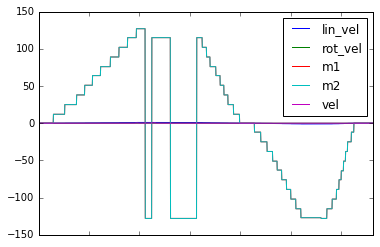

In [37]:
skittish.plot()

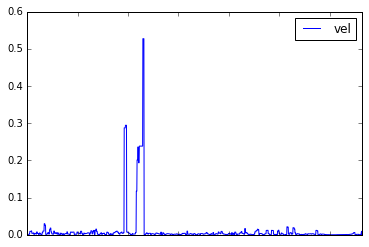

In [38]:
skittish.plot(y=["vel"])

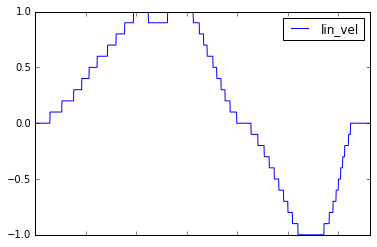

In [39]:
skittish.plot(y=["lin_vel"])

In [40]:
solid = bagToDF("/home/ams/TinyRobo/2018-06-06-14-22-20.bag")

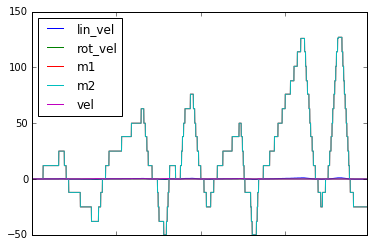

In [41]:
solid.plot()

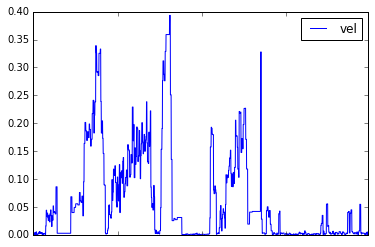

In [42]:
solid.plot(y=["vel"])

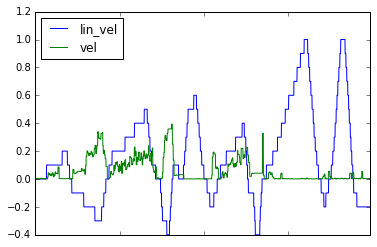

In [43]:
solid.plot(y=["lin_vel","vel"])